In [ ]:
# Install dependencies
!pip install torch torchvision transformers tqdm pillow scipy numpy matplotlib torchmetrics


In [ ]:
# Import libraries
import torch, torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import numpy as np, matplotlib.pyplot as plt, os
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from PIL import Image
from scipy.io import loadmat

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10
LR = 2e-4
Z_DIM = 100
EMBED_DIM = 768  # BERT base hidden size
DATA_PATH = '/content/drive/MyDrive/102flowers/jpg/'
LABEL_PATH = '/content/drive/MyDrive/102flowers/imagelabels.mat'


In [ ]:
# Dataset: Oxford Flowers
class FlowersDataset(Dataset):
    def __init__(self, img_folder, label_path, transform=None, tokenizer=None, bert_model=None):
        self.img_folder = img_folder
        self.transform = transform
        self.tokenizer = tokenizer
        self.bert = bert_model  # Use the BERT model passed during initialization
        self.labels = loadmat(label_path)['labels'][0]
        self.imgs = sorted([os.path.join(img_folder, x) for x in os.listdir(img_folder) if x.endswith('.jpg')])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = f"A photo of a flower of class {self.labels[idx]}"
        tokens = self.tokenizer(caption, return_tensors='pt', truncation=True, padding='max_length', max_length=16)
        with torch.no_grad():
            # Ensure tokens are on the correct device before passing to BERT
            # The BERT model is already on the correct device as it was initialized in the main process
            emb = self.bert(**tokens.to(self.bert.device)).last_hidden_state.mean(dim=1).squeeze(0)
        return emb, image

In [ ]:
import torch.multiprocessing as mp

# Set start method for multiprocessing if not already set
if mp.get_start_method(allow_none=True) is None:
    mp.set_start_method('spawn')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Initialize BERT model in the main process and move it to the device
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Pass the initialized BERT model to the dataset constructor
dataset = FlowersDataset(DATA_PATH, LABEL_PATH, transform, tokenizer, bert_model)
# Set num_workers to 0 to avoid CUDA multiprocessing issues
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
# Model definitions
class Generator(nn.Module):
    def __init__(self, z_dim, embed_dim):
        super(Generator, self).__init__()

        self.embed_proj = nn.Linear(embed_dim, z_dim)

        self.layers = nn.Sequential(
            # Input: z_dim*2 x 1 x 1
            nn.ConvTranspose2d(z_dim * 2, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # This outputs 64x64
            nn.Tanh()
            # 3 x 64 x 64
        )

    def forward(self, noise, embeddings):
        proj_emb = self.embed_proj(embeddings)
        combined = torch.cat([noise, proj_emb], dim=1)
        combined = combined.unsqueeze(2).unsqueeze(3)  # [batch, z_dim*2, 1, 1]
        return self.layers(combined)

class Discriminator(nn.Module):
    def __init__(self, embed_dim):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4
        )

        # Final classification layer - fixed size
        # Adjust input size to accommodate concatenated features and embeddings
        self.fc = nn.Linear(512 * 4 * 4 + embed_dim, 1)

    def forward(self, x, embeddings):
        features = self.conv_layers(x)
        features = features.view(features.size(0), -1)  # Flatten to [batch, 512*4*4]
        # Concatenate features and embeddings before the final linear layer
        combined = torch.cat([features, embeddings], dim=1)
        output = torch.sigmoid(self.fc(combined))
        return output

In [ ]:
# Training loop
gen = Generator(Z_DIM, EMBED_DIM).to(device)
disc = Discriminator(EMBED_DIM).to(device)
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))

for epoch in range(EPOCHS):
    for embeds, imgs in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        embeds, imgs = embeds.to(device), imgs.to(device)
        bs = imgs.size(0)
        noise = torch.randn(bs, Z_DIM, device=device)
        fake_imgs = gen(noise, embeds)

        # Train Discriminator
        real_loss = criterion(disc(imgs, embeds), torch.ones(bs, 1, device=device))
        fake_loss = criterion(disc(fake_imgs.detach(), embeds), torch.zeros(bs, 1, device=device))
        d_loss = (real_loss + fake_loss) / 2
        opt_disc.zero_grad(); d_loss.backward(); opt_disc.step()

        # Train Generator
        g_loss = criterion(disc(fake_imgs, embeds), torch.ones(bs, 1, device=device))
        opt_gen.zero_grad(); g_loss.backward(); opt_gen.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")
    save_image(fake_imgs[:16]*0.5+0.5, f"gen_samples_epoch{epoch+1}.png")


Epoch 1/10: 100%|██████████| 256/256 [03:40<00:00,  1.16it/s]


Epoch [1/10]  D_loss: 0.0684  G_loss: 5.0262


Epoch 2/10: 100%|██████████| 256/256 [02:25<00:00,  1.76it/s]


Epoch [2/10]  D_loss: 0.0992  G_loss: 6.0255


Epoch 3/10: 100%|██████████| 256/256 [02:25<00:00,  1.76it/s]


Epoch [3/10]  D_loss: 0.0156  G_loss: 5.0264


Epoch 4/10: 100%|██████████| 256/256 [02:25<00:00,  1.76it/s]


Epoch [4/10]  D_loss: 0.0053  G_loss: 5.7907


Epoch 5/10: 100%|██████████| 256/256 [02:25<00:00,  1.76it/s]


Epoch [5/10]  D_loss: 0.0162  G_loss: 5.3254


Epoch 6/10: 100%|██████████| 256/256 [02:26<00:00,  1.75it/s]


Epoch [6/10]  D_loss: 0.0051  G_loss: 5.7673


Epoch 7/10: 100%|██████████| 256/256 [02:25<00:00,  1.76it/s]


Epoch [7/10]  D_loss: 0.0021  G_loss: 6.5866


Epoch 8/10: 100%|██████████| 256/256 [02:26<00:00,  1.75it/s]


Epoch [8/10]  D_loss: 0.0007  G_loss: 7.2273


Epoch 9/10: 100%|██████████| 256/256 [02:21<00:00,  1.81it/s]


Epoch [9/10]  D_loss: 0.0007  G_loss: 6.8973


Epoch 10/10: 100%|██████████| 256/256 [02:14<00:00,  1.90it/s]

Epoch [10/10]  D_loss: 0.0003  G_loss: 7.9133


In [ ]:
!pip install torchmetrics


In [ ]:
class FixedFIDCalculator:
    def __init__(self, device):
        self.device = device
        self.model = inception_v3(weights='DEFAULT', transform_input=False).to(device)
        self.model.eval()
        self.model.fc = nn.Identity()

    def preprocess_images(self, images):
        """Convert from [-1,1] to [0,1] and prepare for Inception v3"""
        # Convert to [0,1] range
        images = (images + 1) / 2
        images = torch.clamp(images, 0, 1)

        # Resize to 299x299 for Inception v3
        if images.shape[2] != 299 or images.shape[3] != 299:
            images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

        # Normalize with ImageNet statistics
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)
        images = (images - mean) / std

        return images

    def get_features(self, images):
        images = self.preprocess_images(images)
        with torch.no_grad():
            features = self.model(images)
            return features.cpu().numpy()

    def calculate_fid(self, real_images, fake_images):
        real_features = self.get_features(real_images)
        fake_features = self.get_features(fake_images)

        mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
        mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

        # Add regularization
        eps = 1e-6
        sigma_real += np.eye(sigma_real.shape[0]) * eps
        sigma_fake += np.eye(sigma_fake.shape[0]) * eps

        diff = mu_real - mu_fake
        covmean = sqrtm(sigma_real.dot(sigma_fake))

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
        return fid

# Use the fixed calculator
fid_calc = FixedFIDCalculator(device)
fid_score = fid_calc.calculate_fid(real_images, fake_images)
print(f"Fixed FID: {fid_score:.2f}")

Fixed FID: 354.62


=== COMPREHENSIVE DEBUGGING ===
Real - Shape: torch.Size([32, 3, 64, 64]), Range: [0.000, 1.000]
Fake - Shape: torch.Size([29, 3, 64, 64]), Range: [0.015, 0.985]
Real overall std: 0.272
Fake overall std: 0.149
Fake diversity (per-image std): 0.149


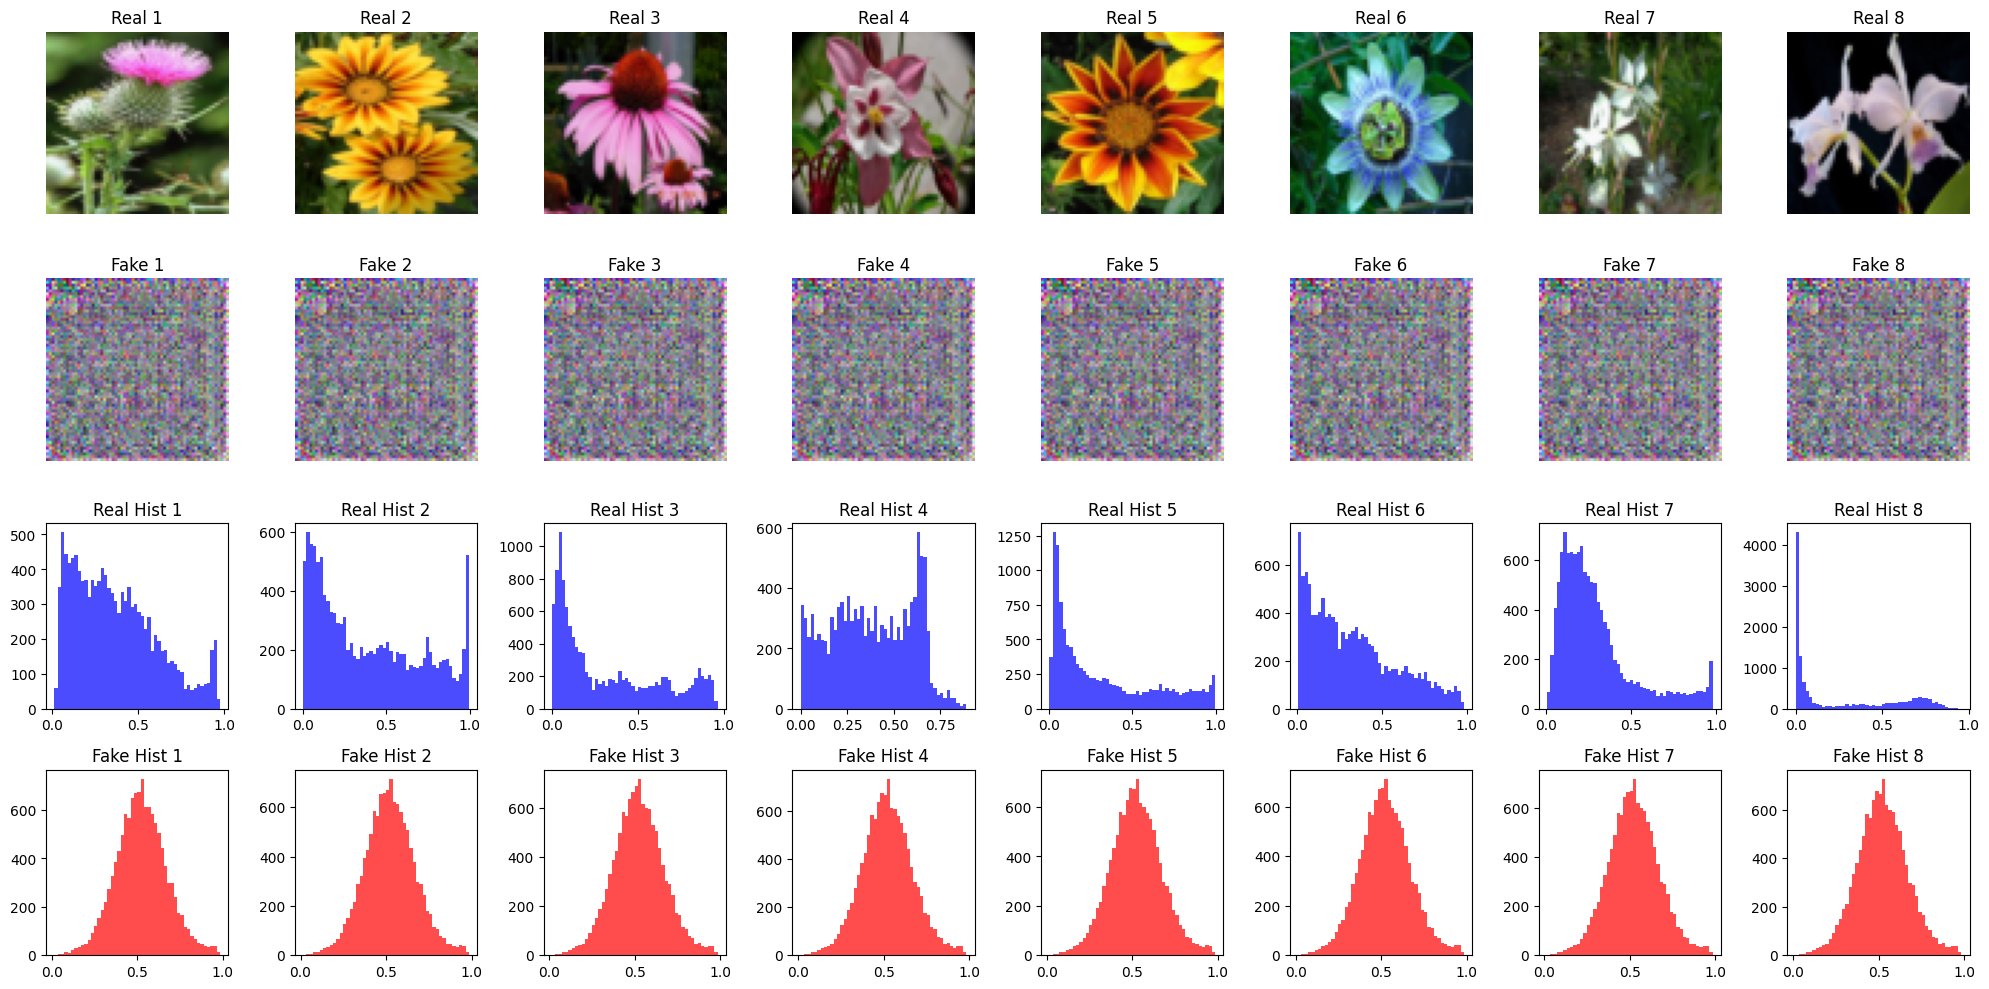

In [ ]:
def comprehensive_debug(real_images, fake_images):
    # Convert to [0,1] for proper visualization
    real_01 = (real_images + 1) / 2
    fake_01 = (fake_images + 1) / 2

    print("=== COMPREHENSIVE DEBUGGING ===")

    # Check basic statistics
    print(f"Real - Shape: {real_images.shape}, Range: [{real_01.min().item():.3f}, {real_01.max().item():.3f}]")
    print(f"Fake - Shape: {fake_images.shape}, Range: [{fake_01.min().item():.3f}, {fake_01.max().item():.3f}]")

    # Check if images are meaningful or just noise
    real_std = real_01.std().item()
    fake_std = fake_01.std().item()
    print(f"Real overall std: {real_std:.3f}")
    print(f"Fake overall std: {fake_std:.3f}")

    # Check for mode collapse (all images identical)
    fake_diversity = torch.std(fake_01.flatten(1), dim=1).mean().item()
    print(f"Fake diversity (per-image std): {fake_diversity:.3f}")

    # Visualize more samples
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))

    for i in range(8):
        # Real images
        real_img = real_01[i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(real_img)
        axes[0, i].set_title(f'Real {i+1}')
        axes[0, i].axis('off')

        # Fake images
        fake_img = fake_01[i].permute(1, 2, 0).cpu().detach().numpy() # Add .detach() here
        axes[1, i].imshow(fake_img)
        axes[1, i].set_title(f'Fake {i+1}')
        axes[1, i].axis('off')

        # Real histograms
        axes[2, i].hist(real_img.ravel(), bins=50, alpha=0.7, color='blue')
        axes[2, i].set_title(f'Real Hist {i+1}')

        # Fake histograms
        axes[3, i].hist(fake_img.ravel(), bins=50, alpha=0.7, color='red')
        axes[3, i].set_title(f'Fake Hist {i+1}')

    plt.tight_layout()
    plt.show()

    # Check if fake images are just noise
    if fake_std < 0.1:
        print("⚠️ WARNING: Fake images have very low variance - might be mostly uniform colors")
    if fake_diversity < 0.1:
        print("⚠️ WARNING: Very low diversity - possible mode collapse")

comprehensive_debug(real_images, fake_images)

=== IMAGE STATISTICS ===
Real - Min: -1.000, Max: 1.000, Mean: -0.211
Fake - Min: -0.970, Max: 0.970, Mean: 0.047
Real has NaN: False, Inf: False
Fake has NaN: False, Inf: False


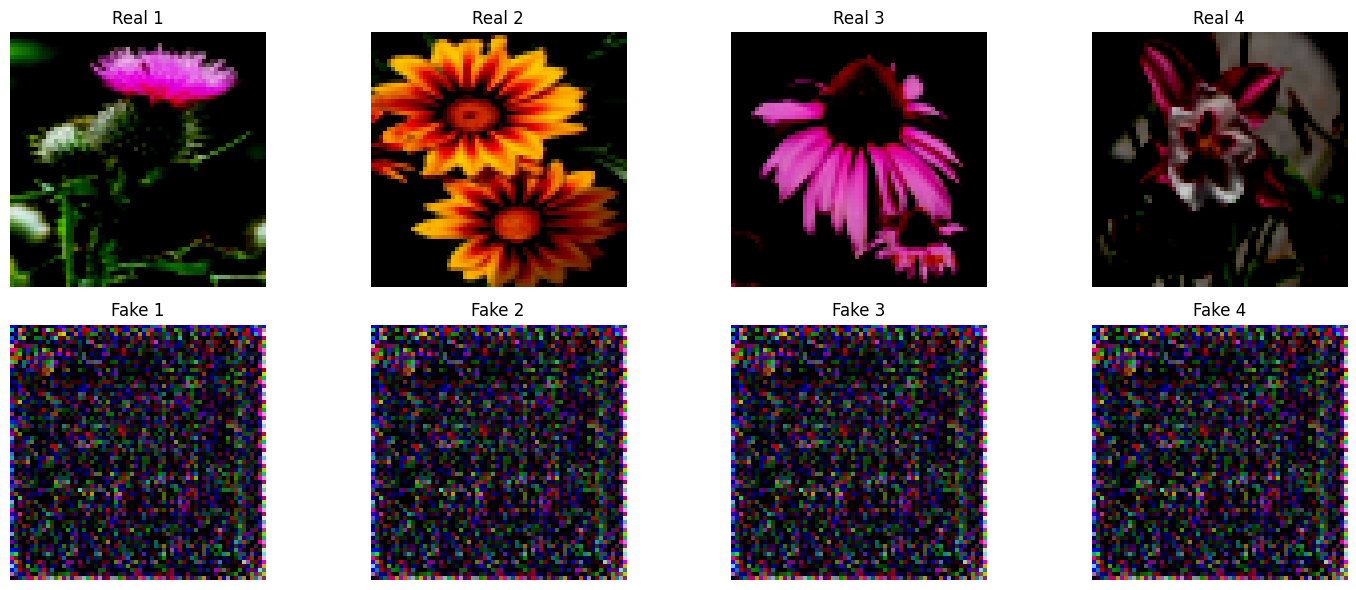

Fake images diversity (std): 0.2972


In [ ]:
import matplotlib.pyplot as plt
import torch

def debug_images(real_images, fake_images, num_samples=4):
    # Check statistics
    print("=== IMAGE STATISTICS ===")
    print(f"Real - Min: {real_images.min().item():.3f}, Max: {real_images.max().item():.3f}, Mean: {real_images.mean().item():.3f}")
    print(f"Fake - Min: {fake_images.min().item():.3f}, Max: {fake_images.max().item():.3f}, Mean: {fake_images.mean().item():.3f}")

    # Check for NaN or Inf values
    print(f"Real has NaN: {torch.isnan(real_images).any().item()}, Inf: {torch.isinf(real_images).any().item()}")
    print(f"Fake has NaN: {torch.isnan(fake_images).any().item()}, Inf: {torch.isinf(fake_images).any().item()}")

    # Visualize
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        # Real images
        real_img = real_images[i].permute(1, 2, 0).cpu().numpy()
        real_img = np.clip(real_img, 0, 1)  # Ensure valid range
        axes[0, i].imshow(real_img)
        axes[0, i].set_title(f'Real {i+1}')
        axes[0, i].axis('off')

        # Fake images
        fake_img = fake_images[i].permute(1, 2, 0).cpu().detach().numpy()
        fake_img = np.clip(fake_img, 0, 1)  # Ensure valid range
        axes[1, i].imshow(fake_img)
        axes[1, i].set_title(f'Fake {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # Check if images are all the same (mode collapse)
    fake_diff = torch.std(fake_images.flatten(1), dim=1).mean()
    print(f"Fake images diversity (std): {fake_diff.item():.4f}")
    if fake_diff < 0.01:
        print("WARNING: Very low diversity - possible mode collapse!")

# Run debugging
debug_images(real_images, fake_images)